# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 100
%matplotlib inline

# Helper Functions

In [2]:
def merge_other_sources(df):
    # Merges the features generated on product_hierarchy and store_cities dataframes with sales data
    
    temp = df.copy()
    
    temp_hier = temp.merge(product_hierarchy[['product_id','deep_hierarchy','number_of_products']], on='product_id')
    
    temp_all = temp_hier.merge(store_cities_pop[['store_id','city_id','pop','number_of_store']], on='store_id')
    
    return(temp_all)

In [3]:
def create_feeatures(df):
    # Creates features for both train and test data
    
    temp = df.copy()
    
    # Date related features
    temp['date'] = pd.to_datetime(temp['date'])
    temp['day_of_month'] = temp['date'].dt.day
    temp['month_of_year'] = temp['date'].dt.month
    temp['day_of_week'] = temp['date'].dt.dayofweek
    temp['year'] = temp['date'].dt.year
    
    # To make bool features to integer 1,0, multiple with 1
    temp['is_month_start'] = temp['date'].dt.is_month_start*1
    temp['is_month_end'] = temp['date'].dt.is_month_end*1
    temp['is_year_start'] = temp['date'].dt.is_year_start*1
    temp['is_year_end'] = temp['date'].dt.is_year_end*1
    
    temp['is_weekend'] = np.where(temp['day_of_week'].isin(['5','6']),1,0)
    
    temp.loc[temp['month_of_year'].isin([3,4,5]), 'season'] = 0
    temp.loc[temp['month_of_year'].isin([6,7,8]), 'season'] = 1
    temp.loc[temp['month_of_year'].isin([9,10,11]), 'season'] = 2
    temp.loc[temp['month_of_year'].isin([12,1,2]), 'season'] = 3
    
    # Calculate product age (day between sales date and launch date)
    temp = temp.merge(product_launched_date, on='product_id')
    temp['product_age'] = (temp['date'] - temp['launch_date']).dt.days
    temp.drop('launch_date',axis=1,inplace=True)
    
    return(temp)

In [4]:
def get_product_launched_day(df):
    # Created product_id, launched_date table for further use
    
    temp = df.copy()
    product_start_date = pd.DataFrame(temp.groupby('product_id')['date'].min()).reset_index()

    product_start_date.columns = ['product_id', 'launch_date']

    product_start_date['launch_date'] = pd.to_datetime(product_start_date['launch_date'])
    
    return(product_start_date)

# Load Data 

In [5]:
sales = pd.read_csv('/Users/emre.atilgan/Desktop/AlgoRun20/data/sales.csv', sep = '|')

final_submission = pd.read_csv('/Users/emre.atilgan/Desktop/AlgoRun20/data/test.csv', sep = '|')

product_hierarchy = pd.read_csv('/Users/emre.atilgan/Desktop/AlgoRun20/data/product_hierarchy.csv', sep = '|')

product_values = pd.read_csv('/Users/emre.atilgan/Desktop/AlgoRun20/data/product_values.csv', sep = '|')

sample_submission = pd.read_csv('/Users/emre.atilgan/Desktop/AlgoRun20/data/sample_submission.csv', sep = '|')

store_cities = pd.read_csv('/Users/emre.atilgan/Desktop/AlgoRun20/data/store_cities.csv', sep = '|')

# Unique Values

We have 3660 different products sold in 48 different stores at the dates between 2017-01-01 and 2019-12-31.

# Hierarchies and Cities Data Sets 

### Hierarchies


In [6]:
product_hierarchy['hierarchy_id_1'] = product_hierarchy['hierarchy_id_1'].astype(str)
product_hierarchy['hierarchy_id_2'] = product_hierarchy['hierarchy_id_2'].astype(str)
product_hierarchy['hierarchy_id_3'] = product_hierarchy['hierarchy_id_3'].astype(str)

In [7]:
product_hierarchy['deep_hierarchy'] = product_hierarchy[['hierarchy_id_1', 'hierarchy_id_2', 'hierarchy_id_3']].agg('_'.join, axis=1)
product_hierarchy['middle_hierarchy'] = product_hierarchy[['hierarchy_id_1', 'hierarchy_id_2']].agg('_'.join, axis=1)
product_hierarchy['top_hierarchy'] =  product_hierarchy['hierarchy_id_1']

In [8]:
product_hierarchy['number_of_products'] = product_hierarchy.groupby('deep_hierarchy')['product_id'].transform(pd.Series.nunique)


In [9]:
product_hierarchy.head()

,product_id,hierarchy_id_1,hierarchy_id_2,hierarchy_id_3,deep_hierarchy,middle_hierarchy,top_hierarchy,number_of_products
0,1,13,14,4,13_14_4,13_14,13,39
1,2,5,12,8,5_12_8,5_12,5,642
2,3,2,3,1,2_3_1,2_3,2,174
3,4,9,11,13,9_11_13,9_11,9,532
4,5,9,6,13,9_6_13,9_6,9,1216


### Cities

In [10]:
# source: 
population = pd.DataFrame({'city':store_cities['city'].unique(),
                           'pop':[2237940,5639076,2511700,3056120,15519267,4367251,2073614,542157,1756353,285410,1407409,983142,1136757]})

In [11]:
store_cities_pop = store_cities.merge(population, on='city')

In [12]:
store_cities_pop['number_of_store'] = store_cities_pop.groupby('city_id')['store_id'].transform(pd.Series.nunique)

In [13]:
store_cities_pop.head()

,store_id,city,city_id,pop,number_of_store
0,22,adana,1,2237940,4
1,16,adana,1,2237940,4
2,57,adana,1,2237940,4
3,73,adana,1,2237940,4
4,1,ankara,2,5639076,7


# Data Cleaning

### Missing Values

In [14]:
# One possible column for missing is sales_quantity
sum(sales.sales_quantity.isna())

0

### Outliers

In [15]:
# Again, only possibilty is that there may be extreme sales_quantites. 
# Mostly zeros, therefore not include the zero values
sales[sales['sales_quantity'] != 0]['sales_quantity'].describe()

count    4.959690e+06
mean     4.169944e+00
std      1.738579e+01
min      1.666667e-01
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.369000e+03
Name: sales_quantity, dtype: float64

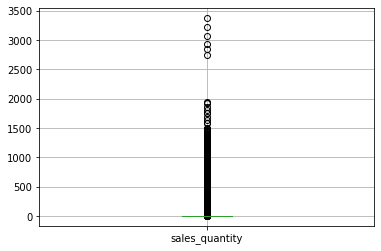

In [16]:
sales[sales['sales_quantity'] != 0].boxplot('sales_quantity')

In [17]:
sales[sales['sales_quantity'] >= 2000]

,store_id,product_id,date,sales_quantity,is_promo
626813,135,2819,2017-09-29,2933.0,0
5262067,94,3302,2017-09-17,2845.0,0
11945517,94,2819,2017-09-30,3369.0,1
13458082,94,3302,2017-08-19,3072.0,0
16801434,94,3302,2017-09-16,2740.0,0
24060021,94,2819,2017-09-29,3219.0,1


In [18]:
sales.groupby('product_id')['sales_quantity'].median().sort_values(ascending=False).head(10)

product_id
2819    48.0
46      29.0
3302    21.0
1900    17.0
2494    10.0
1555     8.0
2095     8.0
141      7.0
344      6.0
2105     5.0
Name: sales_quantity, dtype: float64

In [19]:
sales.groupby('product_id')['sales_quantity'].mean().sort_values(ascending=False).head(10)

product_id
2819    116.194031
46       66.161749
3302     55.887983
344      32.905683
1900     28.946861
1555     22.844707
141      20.870359
2494     20.722819
2105     16.740613
2095     14.975820
Name: sales_quantity, dtype: float64

In [20]:
product_hierarchy[product_hierarchy['product_id'].isin([2819,3302,46,344,1900,1555,141,2494,2105,2095])]

,product_id,hierarchy_id_1,hierarchy_id_2,hierarchy_id_3,deep_hierarchy,middle_hierarchy,top_hierarchy,number_of_products
45,46,1,1,2,1_1_2,1_1,1,112
140,141,1,1,2,1_1_2,1_1,1,112
343,344,1,1,2,1_1_2,1_1,1,112
1554,1555,1,1,2,1_1_2,1_1,1,112
1899,1900,1,1,2,1_1_2,1_1,1,112
2094,2095,1,1,2,1_1_2,1_1,1,112
2104,2105,1,1,2,1_1_2,1_1,1,112
2493,2494,1,1,2,1_1_2,1_1,1,112
2818,2819,1,1,2,1_1_2,1_1,1,112
3301,3302,1,1,2,1_1_2,1_1,1,112


In [21]:
store_cities_pop[store_cities_pop['store_id'] == 94]

,store_id,city,city_id,pop,number_of_store
8,94,ankara,2,5639076,7


PS: Since products are in the water deep hierarchy, we won't delete the extreme values

# Merge All Source Of Information

In [22]:
sales = merge_other_sources(sales)

In [23]:
final_submission = merge_other_sources(final_submission)

# Feature Engineering

Ideas:
- Date features: hangi gün, haftaiçi haftasonu, hangi ay, hangi mevsim, hangi yıl, ramazan mı değil mi, okul açılış tarihleri

- Store&Date = Storun yaşı if önemli
- Product&Date = Product yaşı if önemli
- Product = kaç farklı storeda satılıyor
- City = City_id, competitive number
 

In [ ]:
#store_start_date = pd.DataFrame(sales_all.groupby('store_id')['date'].min()).reset_index()
#store_start_date['date'].value_counts()

In [24]:
product_launched_date = get_product_launched_day(sales)

In [25]:
sales_all = create_feeatures(sales)

In [26]:
final_submission_all = create_feeatures(final_submission)

# Base Models

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

In [28]:
target_col = ['sales_quantity']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(sales_all.drop('sales_quantity',axis=1),
                                                    sales_all['sales_quantity'],
                                                    test_size=0.33,
                                                    random_state=1)

### Means of product_id & date as target

In [30]:
base_1 = pd.DataFrame(sales_all.groupby(['date','product_id'])['sales_quantity'].mean()).reset_index()

In [31]:
base_1

,date,product_id,sales_quantity
0,2017-01-01,1,1.250000
1,2017-01-01,8,1.000000
2,2017-01-01,22,0.076923
3,2017-01-01,25,1.750000
4,2017-01-01,28,0.000000
...,...,...,...
2235111,2019-12-31,3641,0.333333
2235112,2019-12-31,3642,0.333333
2235113,2019-12-31,3645,0.000000
2235114,2019-12-31,3650,0.000000


In [32]:
base_pred_1 = X_test.merge(base_1, on=['date','product_id'])[['sales_quantity']]

In [33]:
np.sqrt(mean_squared_log_error(y_test, base_pred_1))

0.786897772839219

### Means of store_id & date as target

In [34]:
base_2 = pd.DataFrame(sales_all.groupby(['date','store_id'])['sales_quantity'].mean()).reset_index()

In [35]:
base_2

,date,store_id,sales_quantity
0,2017-01-01,1,1.150943
1,2017-01-01,3,0.956522
2,2017-01-01,4,0.039370
3,2017-01-01,7,0.017668
4,2017-01-01,9,0.888889
...,...,...,...
52482,2019-12-31,126,0.106250
52483,2019-12-31,130,0.070588
52484,2019-12-31,131,0.003195
52485,2019-12-31,132,0.012876


In [36]:
base_pred_2 = X_test.merge(base_2, on=['date','store_id'])[['sales_quantity']]

In [37]:
np.sqrt(mean_squared_log_error(y_test, base_pred_2))

0.7486236460880616

### Means of store_id & product_id as target

In [38]:
base_3 = pd.DataFrame(sales_all.groupby(['store_id','product_id'])['sales_quantity'].mean()).reset_index()

In [39]:
base_3

,store_id,product_id,sales_quantity
0,1,1,0.601449
1,1,3,0.708720
2,1,5,0.009524
3,1,7,0.878077
4,1,8,0.087438
...,...,...,...
62558,135,3653,0.032432
62559,135,3655,0.013559
62560,135,3657,0.002375
62561,135,3658,0.004545


In [40]:
base_pred_3 = X_test.merge(base_3, on=['store_id','product_id'])[['sales_quantity']]

In [41]:
np.sqrt(mean_squared_log_error(y_test, base_pred_3))

0.7750521382182208

# Feature Preprocessing

In [44]:
from sklearn import preprocessing

In [42]:
sales_all['city_id'] = sales_all['city_id'].astype(object)
sales_all['year'] = sales_all['year'].astype(object)
sales_all['month_of_year'] = sales_all['month_of_year'].astype(object)
sales_all['season'] = sales_all['season'].astype(object)

In [43]:
final_submission_all['city_id'] = final_submission_all['city_id'].astype(object)
final_submission_all['year'] = final_submission_all['year'].astype(object)
final_submission_all['month_of_year'] = final_submission_all['month_of_year'].astype(object)
final_submission_all['season'] = final_submission_all['season'].astype(object)

In [ ]:
#le = preprocessing.LabelEncoder()
#
#sales_all.columns
#
#cat_cols_for_le = ['middle_hierarchy','deep_hierarchy','year']
#
#for cols in cat_cols_for_le:
#    le = preprocessing.LabelEncoder()
#    
#    le.fit(sales_all[cols])
#    
#    sales_all['{}_le'.format(cols)] = le.transform(sales_all[cols]) 
#    final_submission_all['{}_le'.format(cols)] = le.transform(final_submission_all[cols])

In [45]:
num_cols_for_scale = ['number_of_products','pop','number_of_store','product_age']

In [46]:
for cols in num_cols_for_scale:
    
    col_mean = sales_all[cols].mean()
    col_std = sales_all[cols].std()
    
    sales_all['{}_scaled'.format(cols)] = (sales_all[cols] - col_mean) / col_std
    final_submission_all['{}_scaled'.format(cols)] = (final_submission_all[cols] - col_mean) / col_std
    
    sales_all.drop(cols,axis=1,inplace=True)
    final_submission_all.drop(cols,axis=1,inplace=True)

In [47]:
one_hot_cols = ['deep_hierarchy','city_id',
                'month_of_year','year','season']

In [48]:
for cols in one_hot_cols:
    
    dummies = pd.get_dummies(sales_all[[cols]])
    
    sales_all = pd.concat([sales_all, dummies], axis=1)
    
    sales_all.drop(cols, axis=1, inplace=True)
    
    dummies = pd.get_dummies(final_submission_all[[cols]])
    
    final_submission_all = pd.concat([final_submission_all, dummies], axis=1)
    
    final_submission_all.drop(cols, axis=1, inplace=True)

In [49]:
sales_all.shape

(24500487, 69)

In [50]:
final_submission_all.shape

(6125120, 68)

# Modelling

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [52]:
sales_all.columns

Index(['store_id', 'product_id', 'date', 'sales_quantity', 'is_promo',
       'day_of_month', 'day_of_week', 'is_month_start', 'is_month_end',
       'is_year_start', 'is_year_end', 'is_weekend',
       'number_of_products_scaled', 'pop_scaled', 'number_of_store_scaled',
       'product_age_scaled', 'deep_hierarchy_10_9_9', 'deep_hierarchy_11_13_5',
       'deep_hierarchy_12_16_15', 'deep_hierarchy_13_14_4',
       'deep_hierarchy_14_10_10', 'deep_hierarchy_1_1_2',
       'deep_hierarchy_1_2_3', 'deep_hierarchy_2_3_1', 'deep_hierarchy_3_4_12',
       'deep_hierarchy_3_5_6', 'deep_hierarchy_3_7_6',
       'deep_hierarchy_4_15_17', 'deep_hierarchy_4_15_8',
       'deep_hierarchy_5_12_8', 'deep_hierarchy_6_18_14',
       'deep_hierarchy_7_8_18', 'deep_hierarchy_8_17_11',
       'deep_hierarchy_9_11_13', 'deep_hierarchy_9_6_13',
       'deep_hierarchy_9_6_16', 'deep_hierarchy_9_6_7', 'city_id_1',
       'city_id_2', 'city_id_3', 'city_id_4', 'city_id_5', 'city_id_6',
       'city_id_7', 'c

In [53]:
X_train, X_test, y_train, y_test = train_test_split(sales_all.drop(['store_id', 'product_id', 'date', 'sales_quantity'],axis=1),
                                                    sales_all['sales_quantity'],
                                                    test_size=0.33, random_state=1)

In [55]:
regr = LinearRegression()

In [56]:
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
preds = regr.predict(X_test)

In [58]:
preds = np.where(preds < 0, 0, preds)

In [59]:
np.sqrt(mean_squared_log_error(y_test, preds))

0.6314408742198532

In [60]:
preds_for_final = regr.predict(final_submission_all.drop(['store_id', 'product_id', 'date'],axis=1))

In [61]:
preds_for_final = np.where(preds_for_final < 0, 0, preds_for_final)

In [62]:
preds_for_final

array([1.2387259 , 1.16949773, 0.99221611, ..., 0.        , 0.        ,
       0.24960303])

In [63]:
sample_submission['prediction'] = preds_for_final

# Q2

In [64]:
sample_submission = sample_submission.merge(product_values, on='product_id')

In [70]:
sample_submission['rate_based_value'] = 3000000/sum(np.ceil(sample_submission['prediction']*sample_submission['value']))

In [86]:
sample_submission.head()

,store_id,product_id,date,prediction,order_quantity,value,rate_based_value,order_quantity_raw
0,53,2213,2017-10-04,1.238726,0.0,2.37,0.211923,0.0
1,45,2213,2018-04-25,0.694462,0.0,2.37,0.211923,0.0
2,1,2213,2017-08-26,0.434268,0.0,2.37,0.211923,0.0
3,51,2213,2019-12-11,2.086198,0.0,2.37,0.211923,0.0
4,60,2213,2018-02-21,0.684397,0.0,2.37,0.211923,0.0


In [83]:
sample_submission['order_quantity_raw'] = np.ceil(sample_submission['prediction'])*sample_submission['rate_based_value']

In [84]:
sample_submission['order_quantity_raw'] = np.floor(sample_submission['order_quantity_raw'])

In [85]:
sample_submission['order_quantity'] = sample_submission['order_quantity_raw']*(3000000/sum(sample_submission['order_quantity_raw']))

In [88]:
sample_submission['order_quantity'] = sample_submission['order_quantity'].astype(int)

In [90]:
sample_submission.drop(['value','rate_based_value','order_quantity_raw'], axis=1,inplace=True)

In [91]:
sample_submission.to_csv('/Users/emre.atilgan/Desktop/AlgoRun20/data/ISTOP.csv',sep='|',index=False)